In [2431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2432]:
pd.set_option("display.max_columns", 200)

df = pd.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA210_Practice1_Sales.csv", encoding='latin-1')
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,9963,CA-2015-168088,3/19/2015,3/22/2015,First Class,CM-12655,Corinna Mitchell,Home Office,United States,Houston,Texas,77041,Central,FUR-BO-10004218,Furniture,Bookcases,Bush Heritage Pine Collection 5-Shelf Bookcase...,383.4656,4,0.32,-67.6704
2117,9965,CA-2016-146374,12/5/2016,12/10/2016,Second Class,HE-14800,Harold Engle,Corporate,United States,Newark,Delaware,19711,East,FUR-FU-10002671,Furniture,Furnishings,Electrix 20W Halogen Replacement Bulb for Zoom...,13.4000,1,0.00,6.4320
2118,9981,US-2015-151435,9/6/2015,9/9/2015,Second Class,SW-20455,Shaun Weien,Consumer,United States,Lafayette,Louisiana,70506,South,FUR-TA-10001039,Furniture,Tables,KI Adjustable-Height Table,85.9800,1,0.00,22.3548
2119,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028


In [2433]:
# Поработаем с названием колонок
df.rename(columns=lambda x: x.replace(' ','_').lower(), inplace=True)

In [2434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         2121 non-null   int64  
 1   order_id       2121 non-null   object 
 2   order_date     2121 non-null   object 
 3   ship_date      2121 non-null   object 
 4   ship_mode      2121 non-null   object 
 5   customer_id    2121 non-null   object 
 6   customer_name  2121 non-null   object 
 7   segment        2121 non-null   object 
 8   country        2121 non-null   object 
 9   city           2121 non-null   object 
 10  state          2121 non-null   object 
 11  postal_code    2121 non-null   int64  
 12  region         2121 non-null   object 
 13  product_id     2121 non-null   object 
 14  category       2121 non-null   object 
 15  sub-category   2121 non-null   object 
 16  product_name   2121 non-null   object 
 17  sales          2121 non-null   float64
 18  quantity

In [2435]:
# Поработаем с датами
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])
print(df)

      row_id        order_id order_date  ship_date       ship_mode  \
0          1  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
1          2  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
2          4  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
3          6  CA-2014-115812 2014-06-09 2014-06-14  Standard Class   
4         11  CA-2014-115812 2014-06-09 2014-06-14  Standard Class   
...      ...             ...        ...        ...             ...   
2116    9963  CA-2015-168088 2015-03-19 2015-03-22     First Class   
2117    9965  CA-2016-146374 2016-12-05 2016-12-10    Second Class   
2118    9981  US-2015-151435 2015-09-06 2015-09-09    Second Class   
2119    9990  CA-2014-110422 2014-01-21 2014-01-23    Second Class   
2120    9991  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   

     customer_id     customer_name      segment        country  \
0       CG-12520       Claire Gute     Consumer  United States   
1       CG-12520       Clai

In [2436]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         2121 non-null   int64         
 1   order_id       2121 non-null   object        
 2   order_date     2121 non-null   datetime64[ns]
 3   ship_date      2121 non-null   datetime64[ns]
 4   ship_mode      2121 non-null   object        
 5   customer_id    2121 non-null   object        
 6   customer_name  2121 non-null   object        
 7   segment        2121 non-null   object        
 8   country        2121 non-null   object        
 9   city           2121 non-null   object        
 10  state          2121 non-null   object        
 11  postal_code    2121 non-null   int64         
 12  region         2121 non-null   object        
 13  product_id     2121 non-null   object        
 14  category       2121 non-null   object        
 15  sub-category   2121 n

In [2437]:
# Cколько в среднем доставка товара?
df['time_delivery'] = df['ship_date'] - df['order_date']
df['time_delivery'].mean()

Timedelta('3 days 22:00:30.551626591')

In [2438]:
# Что чаще всего заказывают
max_orders = df['product_id'].value_counts().max()
df['product_name'][max_orders]

"Global Value Mid-Back Manager's Chair, Gray"

In [2439]:
df['category'].unique()

array(['Furniture'], dtype=object)

In [2440]:
df['sub-category'].unique()

array(['Bookcases', 'Chairs', 'Tables', 'Furnishings'], dtype=object)

In [2441]:
# Какая категория самая прибыльная
df.groupby('sub-category')['profit'].sum()

sub-category
Bookcases      -3472.5560
Chairs         26590.1663
Furnishings    13059.1436
Tables        -17725.4811
Name: profit, dtype: float64

In [2442]:
# Какая категория самая прибыльная
df.groupby('sub-category')['profit'].sum().idxmax()

'Chairs'

In [2443]:
# Штат с самым большими количеством заказами
df['state'].value_counts()

state
California              444
New York                236
Texas                   202
Pennsylvania            125
Illinois                123
Washington              114
Ohio                     93
Florida                  85
Virginia                 52
Colorado                 51
Michigan                 50
Arizona                  49
Tennessee                45
North Carolina           42
Massachusetts            33
Georgia                  32
Wisconsin                32
Kentucky                 30
Maryland                 28
New Jersey               26
Indiana                  23
Oregon                   21
Delaware                 18
Rhode Island             16
Oklahoma                 15
Minnesota                13
Connecticut              13
Louisiana                11
Alabama                  11
Missouri                 11
Mississippi               9
Arkansas                  9
Nevada                    9
Utah                      7
New Hampshire             6
South Carolina

In [2444]:
# Штат с самым большими количеством заказами
df['state'].value_counts().idxmax()

'California'

In [2445]:
df.columns

C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'sales', 'quantity', 'discount', 'profit',
       'time_delivery'],
      dtype='object')

## подготовка данных для временного ряда

In [2446]:
drop_columns = ['row_id', 'order_id', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'city', 'state',
       'postal_code', 'product_id', 'category',
       'product_name', 'quantity', 'profit',
                'segment', 'country', 'region', 'sub-category',
                'discount', 'time_delivery'
                ]

df.drop(drop_columns, axis=1, inplace=True)

# df['time_delivery'] = df['time_delivery'].dt.total_seconds() / (24*3600)

In [2447]:
df.set_index('order_date', inplace=True)
df = df.sort_index()

df['day'] = df.index.day  ## создаём колонку дня месяца для анализа сезонности
# df = df.groupby(df.index).sum()  # если несколько доставок в один день
# df = df.asfreq('D').fillna(0)  # заполняем нулями, если нет доставки

# categorical_cols = ['segment', 'country', 'region', 'sub-category']
# numeric_cols = ['discount', 'time_delivery', 'day']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
#         ('num', MinMaxScaler(), numeric_cols)
#     ]
# )

In [2448]:
df = (
    df
    .resample('W-Mon')
    .sum()
    .fillna(0)
)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-06 to 2018-01-01
Freq: W-MON
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   209 non-null    float64
 1   day     209 non-null    int32  
dtypes: float64(1), int32(1)
memory usage: 4.1 KB


In [2449]:
separate_point = int(len(df) * 0.75)

y_train = df['sales'][:separate_point]
y_test = df['sales'][separate_point:]

X_train = df.drop(columns=['sales'])[:separate_point]
X_test = df.drop(columns=['sales'])[separate_point:]

# X_train = pd.DataFrame(
#     preprocessor.fit_transform(X_train),
#     columns=preprocessor.get_feature_names_out()
# )
# X_test = pd.DataFrame(
#     preprocessor.transform(X_test),
#     columns=preprocessor.get_feature_names_out()
# )

## модель XGB

In [2450]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

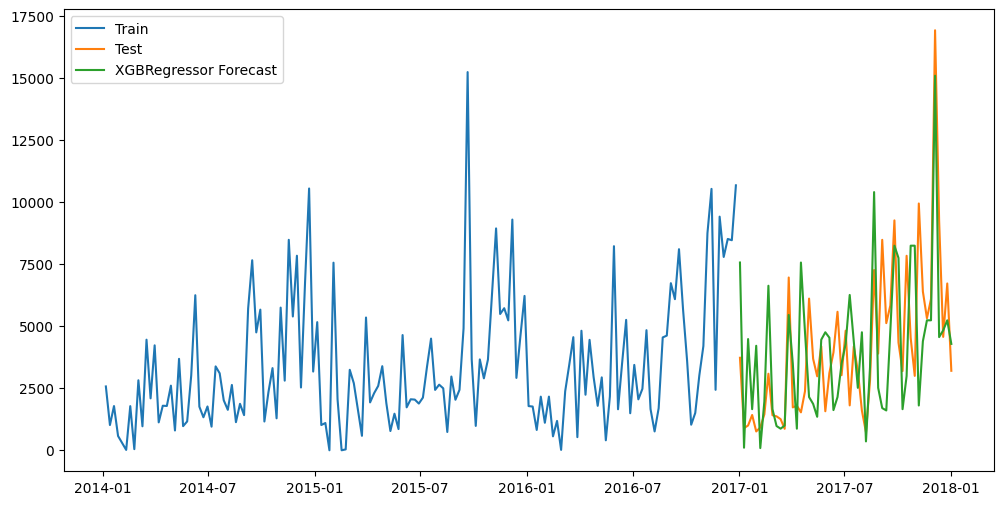

0.09520163715028362
0.7693011194531941
2169.7983959177845


In [2451]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='XGBRegressor Forecast')
plt.legend()
plt.show()

print(r2_score(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

## модель SARIMAX

In [2452]:
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,52)
)
results = model.fit(disp=False)

prediction = results.get_forecast(
    steps=len(y_test),
    exog=X_test[:len(y_test)] 
)
y_pred = prediction.predicted_mean

C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


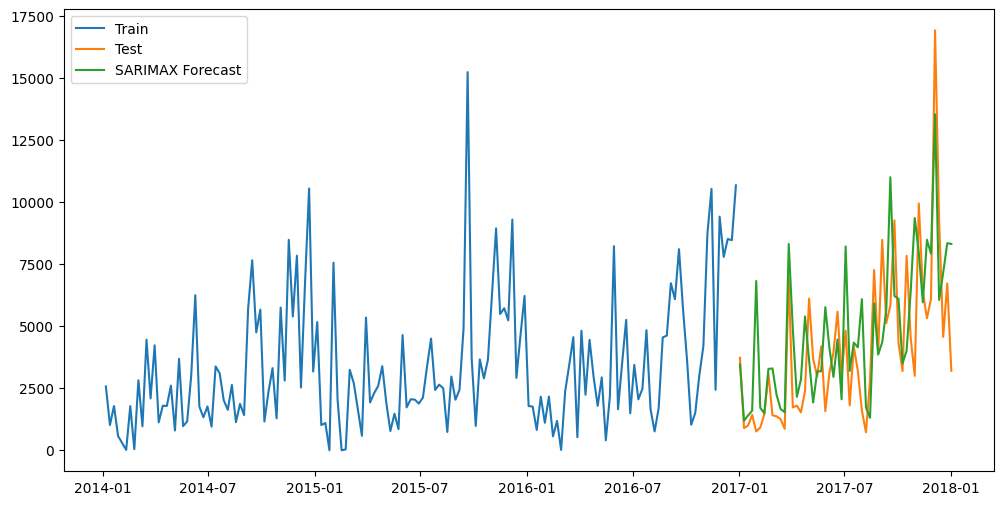

0.3197449183387737
0.7249307114510464
1880.2441895182199


In [2453]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='SARIMAX Forecast')
plt.legend()
plt.show()

print(r2_score(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))